# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

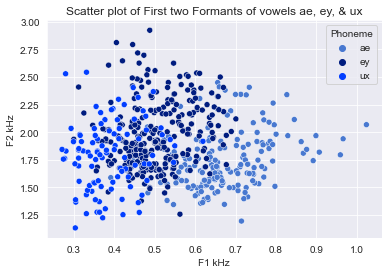

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib notebook

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']

# Plotting here
%matplotlib inline
plt.title("Scatter plot of First two Formants of vowels ae, ey, & ux")
plt.xlabel("F1 kHz")
plt.ylabel("F2 kHz")
sns.scatterplot(data=aes,x="F1",y="F2", hue="Phoneme", palette ="muted") 
sns.scatterplot(data=eys,x="F1",y="F2", hue="Phoneme", palette ="dark")
sns.scatterplot(data=uxs,x="F1",y="F2", hue="Phoneme", palette ="bright")
plt.show()

In [3]:
aes

,SpeakerID,Gender,Phoneme,F1,F2,F3,F4,B1,B2,B3,B4
39,cjf0,F,ae,0.714021,1.999640,2.834684,4.251902,0.162071,0.312755,0.331868,0.444793
171,dml0,F,ae,0.718775,1.862884,2.815234,4.277663,0.150145,0.268921,0.354525,0.407871
205,dml0,F,ae,0.712715,2.342793,2.936107,4.309492,0.193928,0.338076,0.297524,0.422107
585,mem0,F,ae,0.829052,1.967996,3.037148,4.479614,0.243885,0.283130,0.372099,0.413174
597,mem0,F,ae,0.906937,1.818808,2.605929,4.513912,0.146956,0.308710,0.366330,0.407521
...,...,...,...,...,...,...,...,...,...,...,...
12182,dcm0,M,ae,0.617508,1.634245,2.448025,3.890272,0.191030,0.292165,0.279443,0.380274
12194,ded0,M,ae,0.666529,1.559452,2.323424,3.510620,0.184958,0.309526,0.309486,0.401825
12285,dks0,M,ae,0.654254,1.590966,2.374534,3.743037,0.186697,0.316133,0.265717,0.442101
12432,dlm0,M,ae,0.473568,1.662460,2.493703,3.753486,0.216027,0.310498,0.305218,0.341316


Classes difficult to classify
1. ux & ey 
2. ey & ae

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

In [43]:
from statsmodels import api
from scipy import stats
from scipy.optimize import minimize

def datapreprocess (training_data_set):
    models = []
    training_size = 0
    for training_data in training_data_set:
        training_size = training_size + training_data.shape[0]
    for data in training_data_set:
        models.append({'mean': np.mean(data),'cov':np.cov(data, rowvar = False),'prior': data.shape[0]/training_size})
    return models

def classifier (data, models):
    num_classes = len(models)
    num_observations = len(data)
    prediction =[]
    confusion_matrix = np.zeros((num_observations,num_classes))
    rvs =[]
    priors = []
    
    for model in models:
        rvs.append(stats.multivariate_normal(mean=model['mean'],cov=model['cov']))
        priors.append(model['prior'])
    
    for i in range(len(data)):
        for j in range(len(data[i])):
            pred = []
            for model, rv in enumerate(rvs):
                pred.append(rv.pdf(data[i][j])*priors[model])
            prediction = np.argmax(pred)
            confusion_matrix[i][prediction] += 1
    return confusion_matrix


x = [aes[['F1','F2']],eys[['F1','F2']],uxs[['F1','F2']]]

aes_test = test[test["Phoneme"] == 'ae']
eys_test = test[test["Phoneme"] == 'ey']
uxs_test = test[test["Phoneme"] == 'ux']

y =[aes_test[['F1','F2']].to_numpy(),eys_test[['F1','F2']].to_numpy(),uxs_test[['F1','F2']].to_numpy()]

models = datapreprocess(x)
cf_matrix = classifier (y,models)
    
########################################################################################
#def mle (parameters):
#    const, beta, std_dev = parameters
#    pred = const + beta*x

 #   LL = np.sum(stats.norm.logpdf(y, pred, std_dev))
  #  neg_LL = -1*LL
   # return neg_LL
#######################################################################################

(c) To visualize the classes models and the classifier created in (b), plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$, by using the following function.

In [44]:
import scipy.stats

def plotGaussian(mean, cov, color, ax):
    """ 
        Creates a contour plot for a bi-variate normal distribution
        
        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = scipy.stats.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    ax.contour(x,y,lik,colors=color)

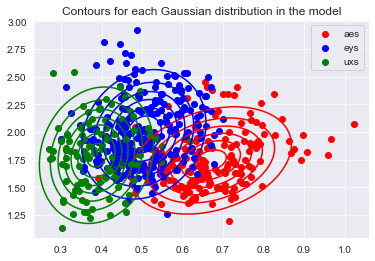

In [45]:
def ScatterPlot(plot_data, name, ax, color):
  
    ax.scatter(plot_data['F1'],plot_data['F2'],label=name, color=color)
    ax.legend()
    
colors = ['r','b', 'g']
fig, ax = plt.subplots()

scatter = [aes, eys, uxs]
names = ['aes', 'eys', 'uxs']
plt.title("Contours for each Gaussian distribution in the model") 
for i, data in enumerate(scatter):
    ScatterPlot(data, names[i], ax, colors[i])

for i, model in enumerate(models):
    plotGaussian(model['mean'], model['cov'],colors[i], ax)


*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

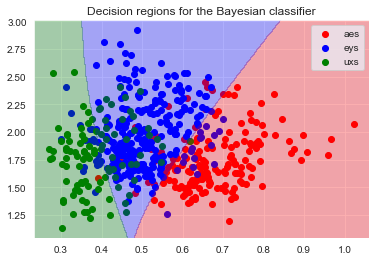

In [46]:
def plot_decision_region(models, colors, ax):
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    
    num_models = len(models)
    #coordinate matrices
    X1, X2 = x.shape
    posterios = np.zeros((X1, X2, num_models))
    
    for idx, model in enumerate(models):
        mvn = stats.multivariate_normal(model['mean'], model['cov'])
        posterios[:, :, idx] = mvn.pdf(xy)*model['prior']
    regions = posterios.argmax(axis=2)
    ax.contourf(x, y, regions, levels=np.arange(-0.5, num_models), colors=colors, alpha= 0.3)
    return regions

colors = ['r','b', 'g']
fig, ax1 = plt.subplots()

plt.title("Decision regions for the Bayesian classifier") 
for idx, data in enumerate(scatter):
    ScatterPlot(data, names[idx], ax1, colors[idx])

regions = plot_decision_region(models, colors, ax1)

(d) Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

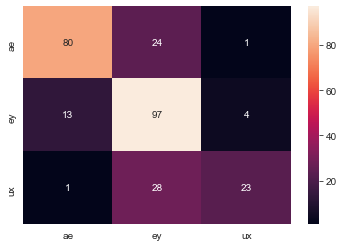

In [47]:
cf_matrix_ = pd.DataFrame(data = cf_matrix,index = ['ae','ey','ux'], columns = ['ae','ey','ux'])
sns.heatmap(cf_matrix_,annot = True)
plt.show()

(e) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (d). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

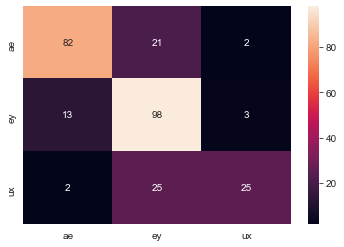

In [48]:
x = [aes[['F1','F2','F3','F4']],eys[['F1','F2','F3','F4']],uxs[['F1','F2','F3','F4']]]
y = [aes_test[['F1','F2','F3','F4']].to_numpy(),eys_test[['F1','F2','F3','F4']].to_numpy(),uxs_test[['F1','F2','F3','F4']].to_numpy()]
models =  datapreprocess(x)
cf_matrix = classifier (y,models)
cf_matrix_ = pd.DataFrame(data = cf_matrix,index = ['ae','ey','ux'], columns = ['ae','ey','ux'])
sns.heatmap(cf_matrix_,annot = True)
plt.show()

As observed, performance of predicting 'ae' does not change when compared to the confusion matrix from (e)
             Improvements are seen in the prediction of phenomes 'ey' and 'ux' in (e)
             The improvement is due to the introduction of more features (formants) 

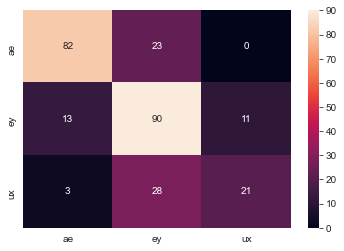

In [49]:
x = [aes[['F1','F2','F3','F4','B1','B2','B3','B4']],eys[['F1','F2','F3','F4','B1','B2','B3','B4']],uxs[['F1','F2','F3','F4','B1','B2','B3','B4']]]
y = [aes_test[['F1','F2','F3','F4','B1','B2','B3','B4']].to_numpy(),eys_test[['F1','F2','F3','F4','B1','B2','B3','B4']].to_numpy(),uxs_test[['F1','F2','F3','F4','B1','B2','B3','B4']].to_numpy()]
models =  datapreprocess(x)
cf_matrix = classifier (y,models)
cf_matrix_ = pd.DataFrame(data = cf_matrix,index = ['ae','ey','ux'], columns = ['ae','ey','ux'])
sns.heatmap(cf_matrix_,annot = True)
plt.show()

It is observed that using more features increases the error.
This indicates that more features makes prediction much difficult. Noise is introduced.

(f) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (e).

In [50]:
def datapreprocess_pro (training_data_set, features):
    models = []
    training_size = 0
    gender = ''
    for training_data in training_data_set:
        for phoneme in training_data:
            training_size = training_size + phoneme.shape[0] 
    for phoneme in training_data_set:
        for gender_data in phoneme:
            gender = gender_data.Phoneme.values  
            vowel = gender_data.Gender.values   
            data = gender_data[features]             
            models.append({'mean': np.mean(data),'cov':np.cov(data, rowvar = False),'prior': data.shape[0]/training_size, 'gender':gender,'phoneme':vowel})
    return models

def classifier_pro (data, models):
    num_observations = len(data)
    prediction =[]
    confusion_matrix = np.zeros((num_observations,num_observations))
    rvs =[]
    priors = []
    
    for model in models:
        rvs.append(stats.multivariate_normal(mean=model['mean'],cov=model['cov']))
        priors.append(model['prior'])

    for i in range(len(data)):
        for j in range(len(data[i])):
            pred = []
            total_pred =[]
            
            for idx, rv in enumerate(rvs):
                pred.append(rv.pdf(data[i][j])*priors[idx])
            for a in range(1,len(pred),2):
                total_pred.append(pred[a-1]+pred[a])
            prediction = np.argmax(total_pred)
            confusion_matrix[i][prediction] += 1
    return confusion_matrix

f_aes = aes[aes["Gender"] == 'F']
m_aes = aes[aes["Gender"] == 'M']
f_eys = eys[eys["Gender"] == 'F']
m_eys = eys[eys["Gender"] == 'M']
f_uxs = uxs[uxs["Gender"] == 'F']
m_uxs = uxs[uxs["Gender"] == 'M']

training_set_mod = np.array([[f_aes,m_aes], [f_eys,m_eys], [f_uxs,m_uxs]],dtype =object)


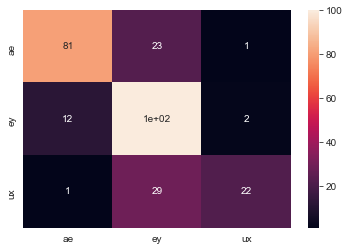

In [51]:
testing_data_f1_f2 =[aes_test[['F1','F2']].to_numpy(),eys_test[['F1','F2']].to_numpy(),uxs_test[['F1','F2']].to_numpy()]
model_f1f2 = datapreprocess_pro(training_set_mod,['F1','F2'])
cf_matrix_f1f2 = classifier_pro(testing_data_f1_f2,model_f1f2)
cf_matrix_ = pd.DataFrame(data = cf_matrix_f1f2,index = ['ae','ey','ux'], columns = ['ae','ey','ux'])
sns.heatmap(cf_matrix_,annot = True)
plt.show()

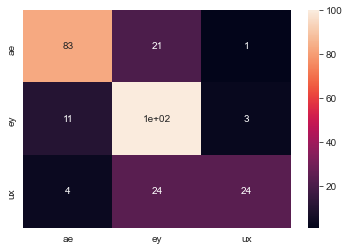

In [52]:
testing_data_f1_f4 =[aes_test[['F1','F2','F3','F4']].to_numpy(),eys_test[['F1','F2','F3','F4']].to_numpy(),uxs_test[['F1','F2','F3','F4']].to_numpy()]
model_f1f4 = datapreprocess_pro(training_set_mod,['F1','F2','F3','F4'])
cf_matrix_f1f4 = classifier_pro(testing_data_f1_f4,model_f1f4)
cf_matrix_ = pd.DataFrame(data = cf_matrix_f1f4,index = ['ae','ey','ux'], columns = ['ae','ey','ux'])
sns.heatmap(cf_matrix_,annot = True)
plt.show()

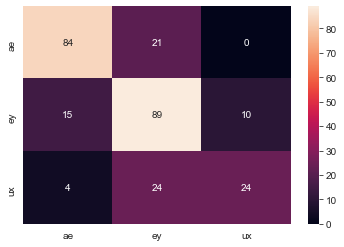

In [53]:
testing_data_f1_b4 =[aes_test[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']].to_numpy(),eys_test[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']].to_numpy(),uxs_test[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']].to_numpy()]
model_f1b4 = datapreprocess_pro(training_set_mod,['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4'])
cf_matrix_f1b4 = classifier_pro(testing_data_f1_b4,model_f1b4)
cf_matrix_ = pd.DataFrame(data = cf_matrix_f1b4,index = ['ae','ey','ux'], columns = ['ae','ey','ux'])
sns.heatmap(cf_matrix_,annot = True)
plt.show()

Introducing a key feature; the gender improved the results in general.

(g) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (f) using only diagonal covariance matrices and compare the results.

In [54]:
def PreProcessing_gender_fullcov(training_data_set, features, id_mat):
    models = []
    gender = ''
    training_size = 0 
    
    for training_data in training_data_set:
        for phoneme in training_data:
            training_size += phoneme.shape[0]
    for phoneme in training_data_set:
        for gender_data in phoneme:
            vowel = gender_data['Phoneme'].values[0]
            gender = gender_data['Gender'].values[0]
            data = gender_data[features]
            models.append({
                'mean': np.mean(data),'cov': np.cov(data, rowvar=False)*id_mat,'prior': data.shape[0]/training_size,'gender': gender,'phoneme': vowel })
    return models


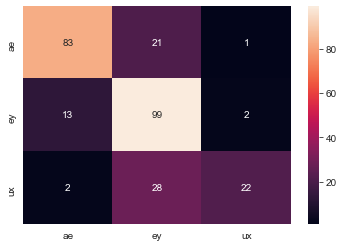

In [55]:
num_features = 2
id_mat = np.eye(num_features)
models_f1_f2_ = PreProcessing_gender_fullcov(training_set_mod, ['F1','F2'], id_mat)
confusion_matrix_gender_f1_f2_fullcov = classifier_pro(testing_data_f1_f2, models_f1_f2_)
cf_matrix_ = pd.DataFrame(data = confusion_matrix_gender_f1_f2_fullcov,index = ['ae','ey','ux'], columns = ['ae','ey','ux'])
sns.heatmap(cf_matrix_,annot = True)
plt.show()

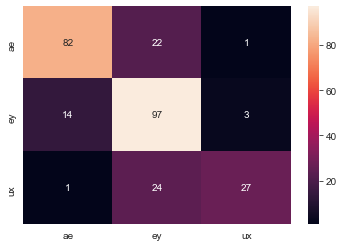

In [56]:
num_features = 4
id_mat = np.eye(num_features)
models_f1_f4_ = PreProcessing_gender_fullcov(training_set_mod, ['F1','F2','F3','F4'], id_mat)
confusion_matrix_gender_f1_f2_fullcov = classifier_pro(testing_data_f1_f4, models_f1_f4_)
cf_matrix_ = pd.DataFrame(data = confusion_matrix_gender_f1_f2_fullcov,index = ['ae','ey','ux'], columns = ['ae','ey','ux'])
sns.heatmap(cf_matrix_,annot = True)
plt.show()

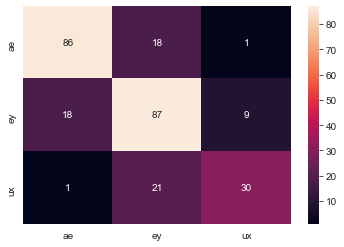

In [57]:
num_features = 8
id_mat = np.eye(num_features)
models_f1_b4 = PreProcessing_gender_fullcov(training_set_mod, ['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4'], id_mat)
confusion_matrix_gender_f1_f2_fullcov = classifier_pro(testing_data_f1_b4, models_f1_b4)
cf_matrix_ = pd.DataFrame(data = confusion_matrix_gender_f1_f2_fullcov,index = ['ae','ey','ux'], columns = ['ae','ey','ux'])
sns.heatmap(cf_matrix_,annot = True)
plt.show()

Results show asimilar trend in predictions although a slight decline in performance can be observed.

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [58]:
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

def Plot_SVM_decision_regions(clf,data,labels):
    '''
    This function is for plotting the decision area of SVM
    
    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    phonemes = np.array(["ae","ey","ux"])

    lables_ = []
    for i in labels:
      lables_.append(phonemes[i])
    
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(phonemes)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #Z = label_encoder.transform(Z) 
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    sns.scatterplot(data[:,0],data[:,1],hue=lables_) 
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Decision Area of SVM')
    plt.show()

def Plot_Support_Vectors(clf,data):
    '''
    This function is for plotting the support vectors of the SVM model
    
    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Support Vectors')
    plt.show()

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

In [59]:
from sklearn.svm import SVC
from sklearn import metrics

def PreProcess_SVC(data,drop,phoneme):


  
  phon = []
  phonem_dict = {}
  for n,i in enumerate(phoneme):
    temp = data[data["Phoneme"] == i] 
    temp = temp.replace(to_replace = i,value = n) 
    phonem_dict[i] = n 
    phon.append(temp)
  
  
  
  data_pre = pd.concat(phon) 
  label_vector = data_pre["Phoneme"] 

  data_pre = data_pre.drop(drop,axis=1) 
  data_pre = data_pre.drop( ["SpeakerID","Gender", "Phoneme"],axis=1)
  
 
  
  feature_matrix = data_pre

  return feature_matrix, label_vector, phonem_dict,

In [60]:
from itertools import combinations
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
""" 
Find best featureset

"""

def possibel_feature_combinations(features):
  comb= []
  for i in range(0,len(features)+1):
      temp = combinations(features,i)
      for j in list(temp):
         comb.append(list(j))

     
  return comb

def cal_error_rate(pred,true):
  error =0
  for n,i in enumerate(pred):
    
    if i != true[n]:
      error +=1
  return round(error/len(pred),3)


def best_features(c,kernel,features,train_data,test_data):
  
  best_feat_dict ={"pen":0,"ker":None,"best_feat":None,"error_rate":1000}
  best_feat_dict_train ={"pen":0,"ker":None,"best_feat":None,"error_rate":1000}
  
  for penalty in c:
    print("Penalty", penalty)
    for ker in kernel:
      print("\t Kernel",ker)
      for feat_set in features:
        for feat in feat_set:
          
          train_f_m, train_l_v, phonem_dict = PreProcess_SVC(train,feat,["ae","ey","ux"])
          test_f_m, test_l_v, phonem_dict = PreProcess_SVC(test,feat,["ae","ey","ux"])

          cls = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel=ker, C=penalty))
          cls.fit( train_f_m.to_numpy(), train_l_v.to_numpy())

          predicted = cls.predict(test_f_m.to_numpy())
        
          error_rate_test = cal_error_rate(predicted,test_l_v.to_numpy())
          
          if error_rate_test < best_feat_dict["error_rate"]:
            best_feat_dict["pen"] = penalty
            best_feat_dict["ker"] = ker
            best_feat_dict["best_feat"] = feat
            best_feat_dict["error_rate"] = error_rate_test
            print("\t \t new",best_feat_dict)

          predicted_train = cls.predict(train_f_m.to_numpy())

          error_rate_train = cal_error_rate(pred = predicted_train,true = train_l_v.to_numpy())
          
          if error_rate_train < best_feat_dict_train["error_rate"]:
            best_feat_dict_train["pen"] = penalty
            best_feat_dict_train["ker"] = ker
            best_feat_dict_train["best_feat"] = feat
          
            best_feat_dict_train["error_rate"] = error_rate_train
            




  return best_feat_dict , best_feat_dict_train

feat = ["F1","F2","F3","F4","B1","B2","B3","B4"]
c =[0.1,1,10]
kernel = ["linear", 'rbf', 'poly', 'sigmoid']

all_features = possibel_feature_combinations(feat)


temp, temp_1 = best_features(c=c,kernel=kernel,features=all_features,train_data = train,test_data=test)
#print(temp)
#print(temp_1)

Penalty 0.1
	 Kernel linear
	 	 new {'pen': 0.1, 'ker': 'linear', 'best_feat': 'F1', 'error_rate': 0.432}
	 	 new {'pen': 0.1, 'ker': 'linear', 'best_feat': 'F2', 'error_rate': 0.273}
	 	 new {'pen': 0.1, 'ker': 'linear', 'best_feat': 'F3', 'error_rate': 0.269}
	 	 new {'pen': 0.1, 'ker': 'linear', 'best_feat': 'B3', 'error_rate': 0.262}
	 Kernel rbf
	 Kernel poly
	 Kernel sigmoid
Penalty 1
	 Kernel linear
	 	 new {'pen': 1, 'ker': 'linear', 'best_feat': 'B2', 'error_rate': 0.258}
	 Kernel rbf
	 Kernel poly
	 Kernel sigmoid
Penalty 10
	 Kernel linear
	 	 new {'pen': 10, 'ker': 'linear', 'best_feat': 'B2', 'error_rate': 0.255}
	 	 new {'pen': 10, 'ker': 'linear', 'best_feat': 'B3', 'error_rate': 0.251}
	 Kernel rbf
	 Kernel poly
	 Kernel sigmoid



 Results for C=0.1


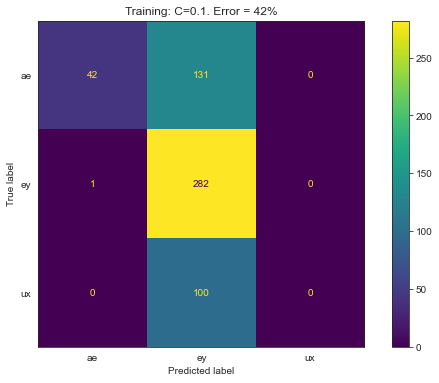

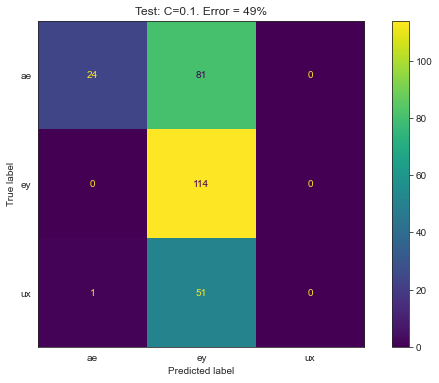

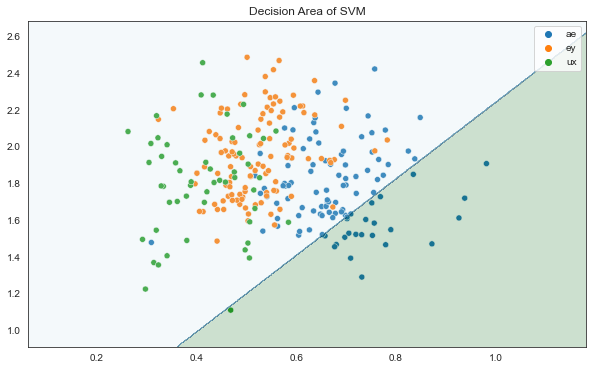

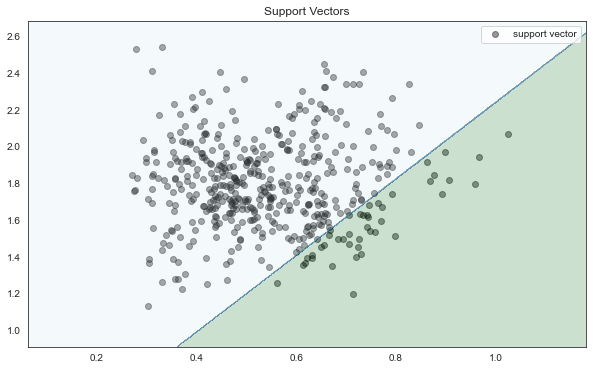


 Results for C=1


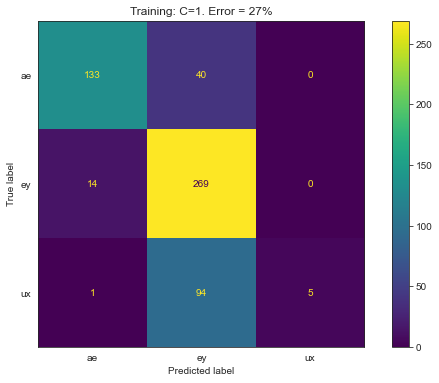

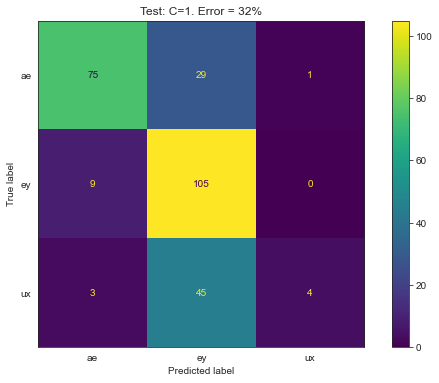

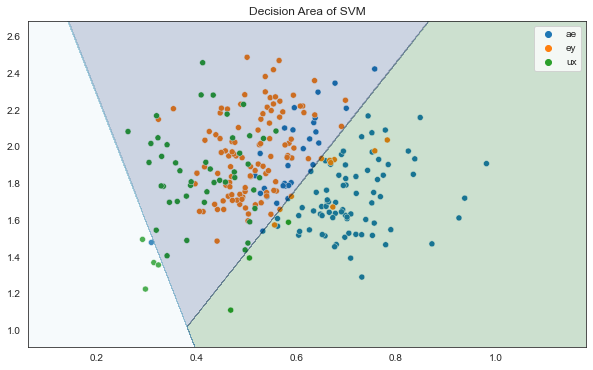

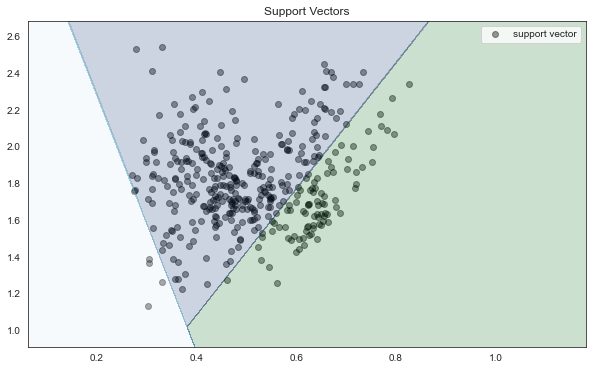


 Results for C=10


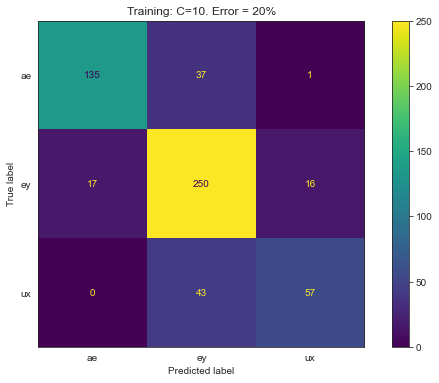

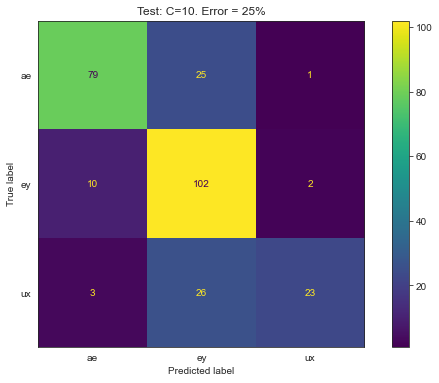

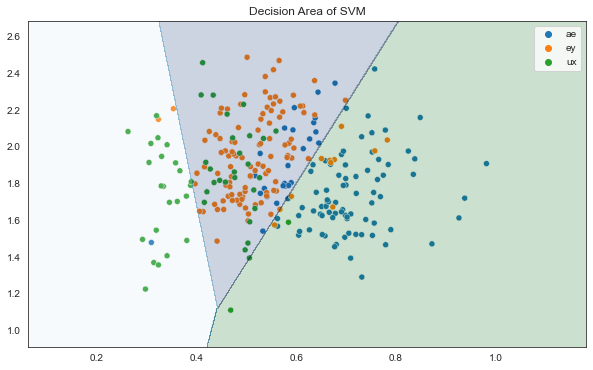

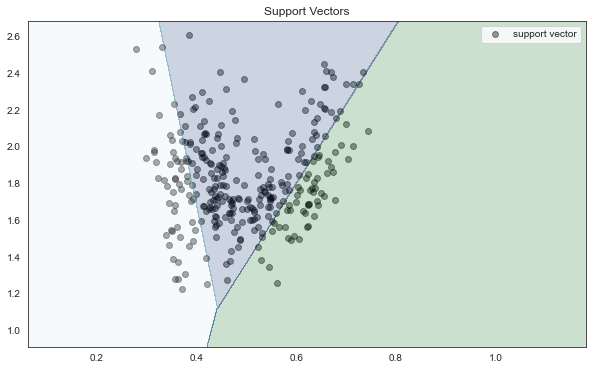

In [61]:
train_f_m, train_l_v, phonem_dict = PreProcess_SVC(train,["F3","F4","B1","B2","B3","B4"],["ae","ey","ux"])
test_f_m, test_l_v, phonem_dict = PreProcess_SVC(test,["F3","F4","B1","B2","B3","B4"],["ae","ey","ux"])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_style("white")

c= [0.1,1,10]
for penalty in c:
  print(f"\n Results for C={penalty}")

  cls = SVC(kernel="linear",C=penalty)
  cls.fit( train_f_m.to_numpy(), train_l_v.to_numpy())
    
    
  #Train Data

  predicted = cls.predict(train_f_m.to_numpy())
  error_rate = cal_error_rate(predicted,train_l_v.to_numpy())
 
  cm_train = confusion_matrix(y_true = train_l_v.to_numpy(), y_pred =predicted)
  disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels= ["ae","ey","ux"])
  fig, ax = plt.subplots(figsize=(10,6))
  disp_train.plot(ax=ax)
  disp_train.ax_.set_title("Training: C={}. Error = {}%".format(penalty,round(error_rate*100),3))

  #Test Data
  predicted = cls.predict(test_f_m.to_numpy())
  error_rate = cal_error_rate(predicted,test_l_v.to_numpy())
  
  cm_test = confusion_matrix(y_true = test_l_v.to_numpy(), y_pred =predicted)
  disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels= ["ae","ey","ux"])
  fig, ax = plt.subplots(figsize=(10,6))
  disp_test.plot(ax=ax)
  disp_test.ax_.set_title("Test: C={}. Error = {}%".format(penalty,round(error_rate*100),2))

  Plot_SVM_decision_regions(cls,test_f_m.to_numpy(),test_l_v.to_numpy())

  Plot_Support_Vectors(cls,test_f_m.to_numpy())  

  plt.show()

Error rate decreases as penalty term increases for both training and test data.

(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

In [62]:
train_f_m, train_l_v, phonem_dict = PreProcess_SVC(train,["B3"],["ae","ey","ux"])
test_f_m, test_l_v, phonem_dict = PreProcess_SVC(test,["B3"],["ae","ey","ux"])



pref = {}
from sklearn.svm import SVC
c= np.arange(0.1,20,0.1)
cs = [[],[],[],[]]
test_c =  [[],[],[],[]]
train_c =  [[],[],[],[]]
for n,k in enumerate(kernel):
  
  for penalty in c:
    
    cls = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel=k, C=penalty))
    cls.fit( train_f_m.to_numpy(), train_l_v.to_numpy())

    #Test data
    predicted = cls.predict(test_f_m.to_numpy())
    error_rate_test = cal_error_rate(predicted,test_l_v.to_numpy())
    

    #train data

    predicted = cls.predict(train_f_m.to_numpy())
    error_rate_train = cal_error_rate(predicted,train_l_v.to_numpy())
    
    
    cs[n].append(penalty)
    
    test_c[n].append(error_rate_test)
    train_c[n].append(error_rate_train)
  pref[k] =temp
  

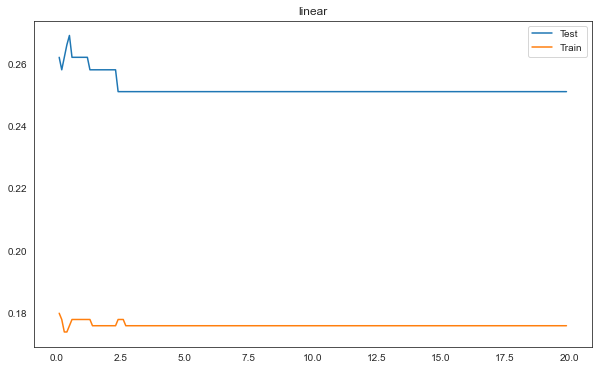

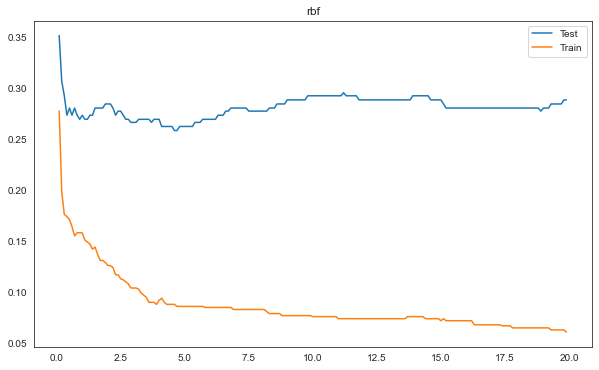

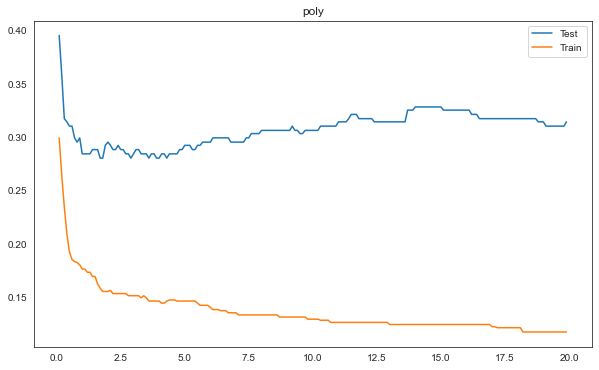

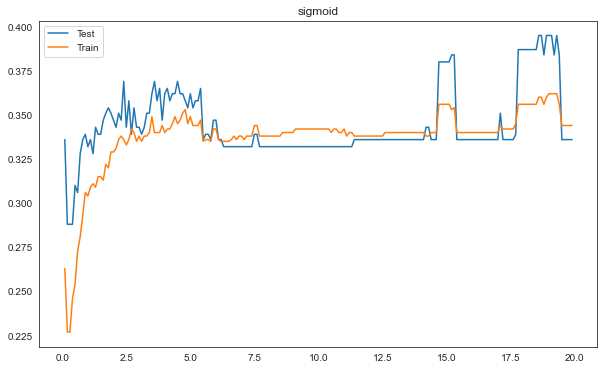

In [63]:
for i in range(len(cs)):
  plt.figure(figsize=(10,6))
  plt.title(kernel[i])
  plt.plot(cs[i],test_c[i],label ="Test")
  plt.plot(cs[i],train_c[i],label ="Train")
  plt.legend()
  plt.show()